# Feature Engineering

## Imports

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")


import joblib
from tqdm.notebook import tqdm as tqdm



import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from prophet import Prophet


In [44]:
# Define metrics

def mae(pred, value):
    return (np.abs(pred - value)).mean()
    
def rmse(pred, value):
    return np.sqrt(((pred-value)**2).mean())


## Import data

In [45]:

import pickle
with open('../Demand Forecasting M5/df.pkl', 'rb') as f:
    df = pickle.load(f)

In [46]:
print(df.columns)

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')


## Data

Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms.

There is no concept of input and output features in time series. Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.
The goal of feature engineering is to provide strong and ideally simple relationships between new input features and the output feature for the supervised learning algorithm to model.


### Label Encoding


Remove unwanted data to create space in RAM for further processing.

Note:
We are storing the categories correponding to their respective category codes.

In [47]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


In [48]:
#Store the categories along with their codes in this way can I remap each term to the original term
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))
index = ['dates', 'd_id', 'd_item_id', 'd_dept_id', 'd_cat_id', 'd_store_id', 'd_state_id']

In [49]:
# save the date column
dates = df.date 

In [50]:
# drop dates from the dataset

df.drop('date',axis=1,inplace=True)

In [ ]:
#import pickle

#data = [index, dates, d_id, d_item_id, d_dept_id, d_cat_id, d_store_id, d_state_id]

#with open("dict.dat", "wb") as pickle_file: # o dict.pkl
#    pickle.dump(data, pickle_file)


In [51]:
# change column 'd':
# from 'd_1' to 1 (as integer) 

df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)

In [52]:
# Convert each column that is category type in numbers

cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes
        

In [53]:
print(df.shape)
print(df.head())

(59181090, 21)
      id  item_id  dept_id  cat_id  store_id  state_id  d  sold  wm_yr_wk  \
0  14370     1437        3       1         0         0  1     0     11101   
1  14380     1438        3       1         0         0  1     0     11101   
2  14390     1439        3       1         0         0  1     0     11101   
3  14400     1440        3       1         0         0  1     0     11101   
4  14410     1441        3       1         0         0  1     0     11101   

   weekday  ...  month  year  event_name_1  event_type_1  event_name_2  \
0        2  ...      1  2011            -1            -1            -1   
1        2  ...      1  2011            -1            -1            -1   
2        2  ...      1  2011            -1            -1            -1   
3        2  ...      1  2011            -1            -1            -1   
4        2  ...      1  2011            -1            -1            -1   

   event_type_2  snap_CA  snap_TX  snap_WI  sell_price  
0            -1     

### Aggregation 

In [54]:
df_aggregation = df.copy()

In [55]:
df_aggregation.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price'],
      dtype='object')

In [56]:
df_aggregation = df_aggregation.set_index(pd.DatetimeIndex(dates))
#df_aggregation['date'] = dates
df_aggregation.shape

(59181090, 21)

In [57]:
df_aggregation = df_aggregation.loc[:][['id','d','dept_id', 'weekday', 'wday', 'month', 'year', 'store_id', 'sold']]
df_aggregation.shape

(59181090, 9)

In [58]:
df_aggregation.head(10)

,id,d,dept_id,weekday,wday,month,year,store_id,sold
date,,,,,,,,,
2011-01-29,14370,1,3,2,1,1,2011,0,0
2011-01-29,14380,1,3,2,1,1,2011,0,0
2011-01-29,14390,1,3,2,1,1,2011,0,0
2011-01-29,14400,1,3,2,1,1,2011,0,0
2011-01-29,14410,1,3,2,1,1,2011,0,0
2011-01-29,14420,1,3,2,1,1,2011,0,0
2011-01-29,14430,1,3,2,1,1,2011,0,0
2011-01-29,14440,1,3,2,1,1,2011,0,12
2011-01-29,14450,1,3,2,1,1,2011,0,2


In [59]:
print(d_dept_id)
print()
print()
print(d_store_id)

{3: 'HOBBIES_1', 4: 'HOBBIES_2', 5: 'HOUSEHOLD_1', 6: 'HOUSEHOLD_2', 0: 'FOODS_1', 1: 'FOODS_2', 2: 'FOODS_3'}


{0: 'CA_1', 1: 'CA_2', 2: 'CA_3', 3: 'CA_4', 4: 'TX_1', 5: 'TX_2', 6: 'TX_3', 7: 'WI_1', 8: 'WI_2', 9: 'WI_3'}


In [60]:
#take only da dept 2 and store 2
df_aggregation = df_aggregation[(df_aggregation.dept_id == 2) & (df_aggregation.store_id == 2)]
df_aggregation.head()

,id,d,dept_id,weekday,wday,month,year,store_id,sold
date,,,,,,,,,
2011-01-29,6142,1,2,2,1,1,2011,2,4
2011-01-29,6152,1,2,2,1,1,2011,2,0
2011-01-29,6162,1,2,2,1,1,2011,2,0
2011-01-29,6172,1,2,2,1,1,2011,2,0
2011-01-29,6182,1,2,2,1,1,2011,2,1


Prendiamo solo i prodotti dello store CA_3 relativi al FOODS_3 che sono lo store e la categoria con più vendite

In [61]:
#remove the period in which the product is not sold

# remove over 20 days of zeros

#create index to remove:
def remove_zeros(df, starts_ends):
    row = df.copy()

    for el in starts_ends:
        start, end = el
        #print(start, end)

        index_start = row.index.get_loc(start)
        #print(index_start)

        index_end = row.index.get_loc(end)

        #print(df.index[index_start : index_end +1])
        #print(slice_remove)
        row.drop(row.index[index_start : index_end ], axis=0, inplace=True)
        #print(row)

    return row

def remove_nan(aggregated, index):
    agg = aggregated[index].dropna(inplace=False)
    return agg





In [62]:
ids = df_aggregation.id.unique().tolist()
dat = df_aggregation.index.unique().tolist()

In [63]:
df_aggregation['year'] = df_aggregation.index.year
df_aggregation['month'] = df_aggregation.index.month
df_aggregation['day'] = df_aggregation.index.day

## Models with Zeros

### Aggregation with zeros


In [64]:
windows = range(1,10)

df_dict = {}

for el in windows:

    df_sold = []
    df_day = []

    for i in list(df_aggregation.id.unique()):
        prod = df_aggregation[df_aggregation.id == i]
        produ = prod.groupby('id')['sold'].resample('%dD' % el).sum().astype(np.float16)
        df_sold.append(list(produ.values))
        df_day.append(list(produ.index.levels[1]))
    
    data = pd.DataFrame(df_sold, columns= df_day[0])
    df_dict['%dD' %el] = data
    #dfs = pd.DataFrame(produ)

In [65]:
df_dict['1D']


,2011-01-29,2011-01-30,2011-01-31,2011-02-01,2011-02-02,2011-02-03,2011-02-04,2011-02-05,2011-02-06,2011-02-07,...,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22
0,4.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,4.0,0.0,...,2.0,2.0,3.0,2.0,3.0,6.0,6.0,2.0,4.0,8.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,5.0,1.0,0.0,2.0,4.0,2.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,2.0,1.0,1.0,3.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4,1.0,3.0,0.0,1.0,4.0,2.0,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,10.0,5.0,4.0,5.0,0.0,3.0,3.0,8.0,4.0,2.0,...,3.0,4.0,2.0,1.0,1.0,4.0,1.0,2.0,1.0,2.0
819,1.0,3.0,1.0,2.0,0.0,1.0,3.0,5.0,2.0,1.0,...,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,3.0,1.0,2.0,1.0
821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Dataset with zeros

In [31]:
tr_data_dict = {}
ts_data_dict = {}
tr_val_dict = {}
for el in windows:
    el = '%dD' % el
    val_size = 28
    sh = df_dict[el].shape[1] - val_size*2


    tr_data = df_dict[el].iloc[: , :sh] 
    ts_data = df_dict[el].iloc[: , sh+val_size:] 
    tr_val = df_dict[el].iloc[: , sh:sh+val_size] 


    tr_data_dict[el] = tr_data
    ts_data_dict[el] = ts_data
    tr_val_dict[el] = tr_val


    #X, y = keras.utils.to_categorical(tr_data.index.weekday.values), tr_data.values
    #X_test, y_test = keras.utils.to_categorical(ts_data.index.weekday.values), ts_data.values

In [32]:
tr_data_dict['1D'].loc[0]

2011-01-29    4.0
2011-01-30    1.0
2011-01-31    1.0
2011-02-01    0.0
2011-02-02    1.0
             ... 
2016-03-23    0.0
2016-03-24    2.0
2016-03-25    1.0
2016-03-26    2.0
2016-03-27    1.0
Name: 0, Length: 1885, dtype: float16

In [33]:
#create dataset for the first product without aggregation

#tr_first = np.expand_dims(tr_data_dict['1D'].loc[0], axis = 0)
tr_first = pd.DataFrame(tr_data_dict['1D'].loc[[0]])
#val_first = np.expand_dims(tr_val_dict['1D'].loc[0], axis = 0)
val_first = pd.DataFrame(tr_val_dict['1D'].loc[[0]])
#test_first = np.expand_dims(ts_data_dict['1D'].loc[0], axis = 0)
test_first  = pd.DataFrame(ts_data_dict['1D'].loc[[0]])

### Dataset with zeros for prob neural model


In [77]:
first_row = df_dict[el].iloc[0,:]

first_row

2011-01-29    4.0
2011-01-30    1.0
2011-01-31    1.0
2011-02-01    0.0
2011-02-02    1.0
             ... 
2016-05-18    6.0
2016-05-19    6.0
2016-05-20    2.0
2016-05-21    4.0
2016-05-22    8.0
Name: 0, Length: 1941, dtype: float16

In [79]:
import keras
i = ids[0]
el = '1D'
sh = df_dict[el].shape[1]





sh = int(sh*0.8)


first_row = df_dict[el].iloc[0,:]


sep = first_row.index[sh]


tr_data = first_row[first_row.index < sep]
ts_data = first_row[first_row.index >= sep]



X, y = keras.utils.to_categorical(tr_data.index.weekday.values), tr_data.values

X_test, y_test = keras.utils.to_categorical(ts_data.index.weekday.values), ts_data.values

2015-04-30 00:00:00
(1552,)
(389,)


### NZ - Probabilistic Neural Model

In [80]:
import keras
from keras import layers
import tensorflow_probability as tfp

def build_probabilistic_regressor(input_shape, hidden):
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    log_rate = layers.Dense(1, activation='linear')(x)
    lf = lambda t: tfp.distributions.Poisson(log_rate=t, force_probs_to_zero_outside_support=False)
    model_out = tfp.layers.DistributionLambda(lf)(log_rate)
    model = keras.Model(model_in, model_out)
    return model

In [81]:
from keras import callbacks
nnpr = build_probabilistic_regressor(X.shape[1], hidden=[32])
negloglikelihood = lambda y_true, dist: -dist.log_prob(y_true)
nnpr.compile(optimizer='Adam', loss=negloglikelihood)
cb = [callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
history = nnpr.fit(X, y.astype(np.float32),validation_split=0.2, callbacks=cb, batch_size=32, epochs=150, verbose=1)


Epoch 1/150
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
39/39 [==============================] - 1s 5ms/step - loss: 1.7309 - val_loss: 2.0174
Epoch 2/150
39/39 [==============================] - 0s 2ms/step - loss: 1.7115 - val_loss: 2.0033
Epoch 3/150
39/39 [==============================] - 0s 2ms/step - loss: 1.6995 - val_loss: 1.9994
Epoch 4/150
39/39 [==============================] - 0s 1ms/step - loss: 1.6909 - val_loss: 1.9922
Epoch 5/150
39/39 [==============================] - 0s 2ms/step - loss: 1.6851 - val_loss: 1.9885
Epoch 6/150
39/39 [==============================] - 0s 2ms/step - loss: 1.6804 - val_loss: 1.9868
Epoch 7/150
39/39 [==============================] - 0s 1ms/step - loss: 1.6761 - val_loss: 1.9842
Epoch 8/150
39/39 [==============================] - 0s 2ms/step - loss: 1.6750 - val_loss: 1.9855
Epoch 9

In [82]:
tr2, vl2 = history.history["loss"][-1], np.min(history.history["val_loss"])
print(f'Loss: {tr2:.4f} (training, final), {vl2:.4f} (validation, best)')

Loss: 1.6680 (training, final), 1.9814 (validation, best)


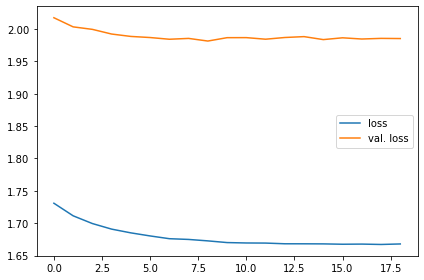

In [83]:
def plot_training_history(history, autoclose=True):
    if autoclose:
        plt.close('all')
    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    if 'val_loss' in history.history.keys():
        plt.plot(history.history['val_loss'], label='val. loss')
        plt.legend()
    plt.tight_layout()


plot_training_history(history)

In [95]:
def plot_pred_scatter(y_pred, y_true, autoclose=True):
    if autoclose:
        plt.close('all')
    plt.figure()
    plt.scatter(y_pred, y_true, marker='.', alpha=0.1)
    xl, xu = plt.xlim()
    yl, yu = plt.ylim()
    l, u = min(xl, yl), max(xu, yu)
    plt.plot([l, u], [l, u], ':', c='0.3')
    plt.xlim(l, u)
    plt.ylim(l, u)
    plt.xlabel('prediction')
    plt.ylabel('target')
    plt.tight_layout()

    from sklearn import metrics

In [96]:
#rmse with zeros

tr_preds = nnpr(X).mean()

print(f'MAE: {metrics.mean_absolute_error(y, tr_preds)}')

print('RMSE:', rmse(np.array(tr_preds), y))

MAE: 1.2354267835617065
RMSE: 1.979773


In [97]:
#rmse with zeros

ts_preds = nnpr(X_test).mean()

print(f'MAE: {metrics.mean_absolute_error(y_test, ts_preds)}')


print('RMSE:', rmse(np.array(ts_preds), y_test))

MAE: 1.124037504196167
RMSE: 1.5226504


### Naive approach


The naive approach forecasts the next day's sales as the current day's sale.

In practice the prediction of the model for today (yt), is the predicted value for the next day (yt-1). 
The model predicts tomorrow's sales as today's sales. 

In [38]:
predictions_naive = []

for i in range(val_size):
    if i == 0:
        predictions_naive.append(tr_first[tr_first.columns[-1]].values) # takes the last value (column) of the train_dataset
    else:
        predictions_naive.append(val_first[val_first.columns[i-1]].values) # takes the previous value as the actual value


predictions_naive = np.transpose(np.array(predictions_naive))
# Root mean squared error
error_naive_rmse = rmse(predictions_naive, val_first.values)
print(error_naive_rmse)
# Mean absolute error
error_naive_mae = mae(predictions_naive,val_first.values)

print(error_naive_mae)

3.365
2.678


### Moving Average

The moving average calculates the mean sales over the previous 28 (or any other number) days and forecasts that as the next day's sales. This method takes the previous 30 timesteps into consideration, and is therefore less prone to short term fluctuations than the naive approach.

In [39]:
def moving_avg(data, val, window_size):
  predictions_ma = []

  for i in range(val_size):
      if i == 0:
          predictions_ma.append(np.mean(data[data.columns[-window_size:]].values, axis=1))

      if i < val_size+1 and i > 0:
          predictions_ma.append((np.mean(data[data.columns[-window_size+i:]].values, axis=1) + np.mean(predictions_ma[:i], axis=0))*0.5)
      if i > val_size+1:
          predictions_ma.append(np.mean([predictions_ma[:i]], axis=1))
      
  predictions_ma = np.transpose(np.array(predictions_ma))
  error_mae = mae(predictions_ma,val.values)
  error_ma_rmse = rmse(predictions_ma, val.values)
  print(error_ma_rmse)
  return predictions_ma, error_ma_rmse



window=[7,14,21,28,35,42,49,60,70,80,90]
for i in window:
  print("rmse with window "+ str(i) + ":")
  moving_avg(tr_first, val_first, i)



rmse with window 7:
2.395
rmse with window 14:
2.408
rmse with window 21:
2.324
rmse with window 28:
2.281
rmse with window 35:
2.307
rmse with window 42:
2.309
rmse with window 49:
2.312
rmse with window 60:
2.338
rmse with window 70:
2.348
rmse with window 80:
2.336
rmse with window 90:
2.34


In [40]:
# choose the best window
predictions_ma, error_ma_rmse = moving_avg(tr_first, val_first, 28)

2.281


### ARIMA 

ARIMA stands for Auto Regressive Integrated Moving Average. ARIMA models aims at describing the correlations in the time series.

In [41]:

df = tr_first.T
df.columns = ['value']



In [42]:
df

,value
2011-01-29,4.0
2011-01-30,1.0
2011-01-31,1.0
2011-02-01,0.0
2011-02-02,1.0
...,...
2016-03-23,0.0
2016-03-24,2.0
2016-03-25,1.0
2016-03-26,2.0


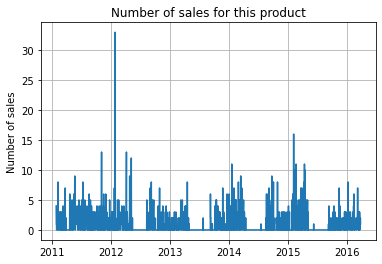

In [43]:
import matplotlib.pyplot as plt
ts = df['value']
plt.plot(ts)
plt.title('Number of sales for this product')
plt.ylabel('Number of sales')
plt.grid()
plt.show()

In [44]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

check_stationarity(df)


The series is stationary


In [369]:
#Since the time series is not stationary, I transform it, by differencing once and I check again for stationarity.

#df_diff = df.diff()
#df_diff.dropna(inplace=True)
#check_stationarity(df_diff)


Now, the time series is stationary, thus I can set the difference order for the training model to 1.

d = 1

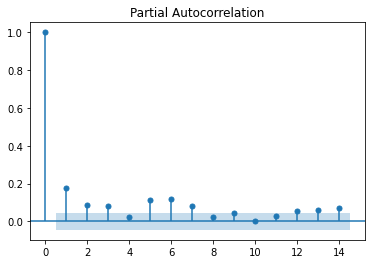

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# identifica P, cioè AR
plot_pacf(df, lags =14)
plt.show()

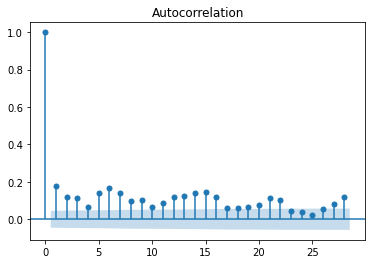

In [50]:
#identifica la Q, cioè MA
plot_acf(df, lags =28)
plt.show()

In [416]:
predictions_arima = []
#for row in tr_first.values[:1]:
    #row = row.astype('int')
model = sm.tsa.statespace.SARIMAX(df, seasonal_order=(3, 0, 3, 7)) #(p,d,q,s)
model_fit = model.fit()
predictions_arima.append(model_fit.forecast(val_size))
predictions_arima = np.array(predictions_arima).reshape((-1, val_size))
print(predictions_arima)
error_arima_rmse = rmse(predictions_arima[0],val_first.values[0])
print(error_arima_rmse)

[[1.41671165 0.72283669 0.85717495 0.63456908 0.58918043 1.25374592
  1.27416703 1.20753222 0.69127196 0.9469697  0.66075438 0.77771245
  1.31229406 1.19724928 1.31278738 0.64493299 0.82793002 0.53002006
  0.53305977 1.23669694 1.24536308 1.26463926 0.72559273 0.95522708
  0.70383347 0.79561248 1.31468959 1.20820618]]
2.5412672015590365


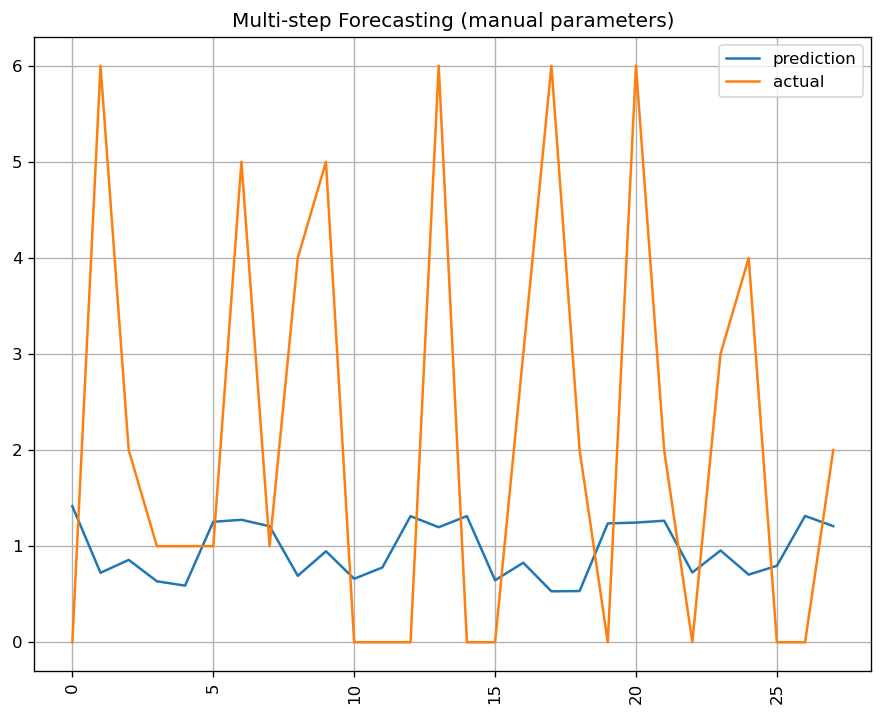

In [417]:
plt.plot(predictions_arima[0], label='prediction')
plt.plot(val_first.values[0], label='actual')
plt.title('Multi-step Forecasting (manual parameters)')
plt.legend()
plt.grid()
plt.xticks(rotation=90)
plt.show()

ARIMA is able to find low-level and high-level trends simultaneously, unlike most other models which can only find one of these. It is able to predict a periodic function for each sample, and these functions seem to be pretty accurate (except for the second sample).

### Prophet 


Prophet is an opensource time series forecasting project by Facebook. It is based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, including holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. It is also supposed to be more robust to missing data and shifts in trend compared to other models.

In [52]:
predictions_prophet = []

df = tr_first.T
df = df.reset_index(level=0)
df.columns = ['ds','y']


model = Prophet(daily_seasonality=True, seasonality_mode = 'multiplicative')
model.fit(df)
future = model.make_future_dataframe(periods=val_size)

forecast = model.predict(future)

forecast = forecast["yhat"]

forecast = forecast[-val_size:].values


predictions_prophet.append(forecast)
predictions_prophet = np.array(predictions_prophet).reshape((-1, val_size))

error_prophet_rmse = rmse(predictions_prophet[:1], val_first.values[:1])
print(error_prophet_rmse)

14:49:53 - cmdstanpy - INFO - Chain [1] start processing
14:49:53 - cmdstanpy - INFO - Chain [1] done processing


2.420533865906885


### Random Forest Regressor

In [165]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

import joblib
import warnings
warnings.filterwarnings("ignore")


In [166]:
tr_data_dict = {}
ts_data_dict = {}
tr_val_dict = {}
for el in windows:
    el = '%dD' % el
    predictions = 28
    sh = df_dict[el].shape[1] - predictions*2


    tr_data = df_dict[el].iloc[: , :sh+predictions] #0 a 971-28+1 = 944 escluso
    ts_data = df_dict[el].iloc[: , predictions*2:] #
    tr_val = df_dict[el].iloc[: , predictions:sh+predictions+predictions] 

    X_tr, y_tr = tr_data.iloc[: , :-predictions], tr_data.iloc[: , -predictions:]
    X_ts, y_ts = ts_data.iloc[: , :-predictions], ts_data.iloc[: , -predictions:]
    X_val, y_val = tr_val.iloc[: , :-predictions], tr_val.iloc[: , -predictions:]

    tr_data_dict[el] = [X_tr, y_tr]
    ts_data_dict[el] = [X_ts, y_ts]
    tr_val_dict[el] = [X_val, y_val]


    #X, y = keras.utils.to_categorical(tr_data.index.weekday.values), tr_data.values
    #X_test, y_test = keras.utils.to_categorical(ts_data.index.weekday.values), ts_data.values

In [167]:
#create dataset for the first product without aggregation

x_first = np.expand_dims(tr_data_dict['1D'][0].loc[0].values, axis = 0)
y_first = np.expand_dims(tr_data_dict['1D'][1].loc[0].values, axis = 0)
x_val_first = np.expand_dims(tr_val_dict['1D'][0].loc[0].values, axis = 0)
y_val_first = np.expand_dims(tr_val_dict['1D'][1].loc[0].values, axis = 0)
x_test_first = np.expand_dims(ts_data_dict['1D'][0].loc[0].values, axis = 0)
y_test_first = np.expand_dims(ts_data_dict['1D'][1].loc[0].values, axis = 0)

In [168]:
# Random Forest Regression for the first product

model_rf = RandomForestRegressor()
model_rf.fit(x_first,y_first)
#joblib.dump(model_rf2, "./random_forest.joblib")

y_val_pred  = model_rf.predict(x_val_first)
rmse_rf = rmse(y_val_first, y_val_pred)
print(rmse_rf)

2.9459415181858972


In [169]:
# Random Forest Regression to the dataset

rmse_list = []
for el in windows:
    el = '%dD' % el
    model_rf = RandomForestRegressor()
    model_rf.fit(tr_data_dict[el][0], tr_data_dict[el][1])
    #joblib.dump(model_rf2, "./random_forest.joblib")

    y_val_pred  = model_rf.predict(tr_val_dict[el][0])
    rmse_list.append(rmse(tr_val_dict[el][1], y_val_pred))
print(rmse_list)

[2016-04-25    4.844198
2016-04-26    3.781332
2016-04-27    4.043893
2016-04-28    3.574393
2016-04-29    5.289127
2016-04-30    4.268694
2016-05-01    4.346917
2016-05-02    3.909452
2016-05-03    3.406380
2016-05-04    3.744683
2016-05-05    3.477394
2016-05-06    4.244636
2016-05-07    4.883528
2016-05-08    5.051044
2016-05-09    4.187625
2016-05-10    3.866930
2016-05-11    4.212818
2016-05-12    3.332154
2016-05-13    4.193923
2016-05-14    4.475264
2016-05-15    5.657665
2016-05-16    3.454583
2016-05-17    3.861353
2016-05-18    3.422972
2016-05-19    3.636983
2016-05-20    3.903403
2016-05-21    5.178174
2016-05-22    4.655386
dtype: float64, 2016-03-29     5.346381
2016-03-31     8.272584
2016-04-02     8.119825
2016-04-04     7.282576
2016-04-06     6.862150
2016-04-08     8.051173
2016-04-10     9.288572
2016-04-12     7.200835
2016-04-14     7.872025
2016-04-16    11.059788
2016-04-18     7.428023
2016-04-20     6.270568
2016-04-22     8.528924
2016-04-24     9.656446
201

vogliamo due casi diversi:
1. il primo è che CATEGORIZZIAMO l'input in base al giorno della settimana e prediciamo le vendite in base a quel giorno. otteniamo però 7 categorie [NOTA: STIAMO CONSIDERANDO SOLO 1 PRODOTTO]
- POSSIBILITÀ future: 
-- categorizzare a 2 giorni consecuti della settimana [ es. LM, MG, VSD] in modo da avere il doppio dei campioni.
-- aggiungo più prodotti
-- prendo il prodotto e faccio una NN con le features del giorno [rolling average, moving average, snap]

Modelli da avere(con dataset senza zeri):
1. Probabilistic model Poisson
2. NN con features (futura)

2. il secondo è gestire il dataset come time series: in input avremo le vendite fino ad una certa data. La y saranno le vendite successive a quella data. 
 -Si lavora solo con gli zeri.
1. random forest regressor
2. MA
3. ARIMA
4. naive
5. Prophet

